# Code for the paper "Vaccination strategies when vaccines are scarce: Conflicts between reducing burden and avoiding the evolution of escape mutations"

In [1]:
import numpy as np
from math import *
import os
import sys
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.integrate import simps
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import matplotlib.ticker

plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['figure.dpi'] = 100

class FFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, fformat="%1.1f", offset=True, mathText=True):
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self, useOffset=offset, useMathText=mathText)
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % self.format

In [2]:
print(sys.version)
print(np.__version__)
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
import scipy
print(scipy.__version__)
!jupyter --version

3.9.4 (default, Apr  9 2021, 16:34:09) 
[GCC 7.3.0]
1.20.1
matplotlib: 3.3.4
1.6.2
jupyter core     : 4.7.1
jupyter-notebook : not installed
qtconsole        : not installed
ipython          : 7.22.0
ipykernel        : 5.3.4
jupyter client   : 6.1.12
jupyter lab      : not installed
nbconvert        : not installed
ipywidgets       : not installed
nbformat         : not installed
traitlets        : 5.0.5


In [3]:
# WLOG, the population size is set to 1
n = 1
# Default parameter values
R0D = 1.2
R01D = 0.9
R02D = 2
gammaD = 0.2
betaD = R0D * gammaD
I0D = 2e-3      # In Germany 01-01-2021: 17007 daily new cases (you have to multiply by 5 to get the number of infected and by 2 to take into account the undetected cases) Source: https://www.worldometers.info/coronavirus/country/germany/
Rec0D = 4e-2    # In Germany 01-01-2021: 1762525 total cases (you have to multiply by 2 to take into account the undetected cases)
mu1D = 1e-6
mu_ratioD = 10
lD = n * 0.2 / 100 # There are 0.2% of the pop size doses available each day
wD = 20
w_min = 20
tau_max = 1 / w_min
xD = 0.5
yD = 1
TcD = 10
IcD = I0D / 10
VcD = 10

In [4]:
# Parameters for the numerical solution
tmax = 1000
nbSteps = 1000
tV = np.linspace(0, tmax, nbSteps + 1)
relativeTolerance = 1e-9
absoluteTolerance = 1e-9

tick_label_size = 15
fontsize = 17
fontsize_legend = 15

### The model

In [5]:
def model(t, xV, beta, gamma, l, tau, x, y):
    S = xV[0]
    VH = xV[1]
    VF = xV[2]
    I = xV[3]
    VS = xV[4]
    R = xV[5]
    if S < 0:
        #S = 0
        dSdt = 0
    else:
        dSdt = - (l - tau * VH)
    dSdt -= beta * S * (I + y * VS) / n
    if S < 0:
        if VH < 0:
            #VH = 0
            dVHdt = 0
        else:
            dVHdt = - min(l, tau_max * VH)
    else:
        dVHdt = l - 2 * tau * VH
    dVHdt -= x * beta * VH * (I + y * VS) / n
    if S < 0:
        if VH < 0:
            dVFdt = 0
        else:
            dVFdt = min(l, tau_max * VH)
    else:
        dVFdt = tau * VH
    dIdt = (beta * S * (I + y * VS) / n) - gamma * I
    dVSdt = (x * beta * VH * (I + y * VS) / n) - gamma * VS
    dRdt = gamma * I + gamma * VS
    syst = [dSdt, dVHdt, dVFdt, dIdt, dVSdt, dRdt]
    return syst

### Compute the metrics

In [6]:
def solve_and_plot(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, mu1=mu1D, mu_ratio=mu_ratioD, l=lD, w=wD, x=xD, y=yD,
                   isPlot=True, logScale=False, file_name="dynamics_default"):
    beta = R0 * gamma
    tau = 1 / w
    mu2 = mu1 * mu_ratio
    x0 = [(1 - I0 - Rec0) * n, 0, 0, I0 * n, 0, Rec0 * n]
    res = solve_ivp(model, [0, tmax], x0, t_eval=tV, rtol=relativeTolerance, atol=absoluteTolerance,
                    args=(beta, gamma, l, tau, x, y))
    if not res.success:
        print(res.message)
    sol = res.y

    if isPlot:
        labels=['S', '$V^H$', '$V^F$', '$I$', '$V_I^H$', 'R']
        plt.rc('xtick', labelsize=tick_label_size)
        plt.rc('ytick', labelsize=tick_label_size)
        # color_map = ['#006ddb', '#6db6ff', '#b6dbff', '#ff6db6', '#ffb6db', '#db6d00']
        color_map = ['#b6dbff', '#6db6ff', '#006ddb', '#ffb6db', '#ff6db6', '#db6d00']
        # line_styles = ['-', '--', ':', '-', '-', '-']
        line_styles = [':', '--', '-', ':', '-', ':']
        for i, x in enumerate(sol):
            plt.plot(res.t[:300], x[:300], label=labels[i], linewidth=3, color=color_map[i], linestyle=line_styles[i])
        plt.ylabel('Fraction', fontsize=fontsize)
        plt.xlabel('Days', fontsize=fontsize)
        plt.legend(fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left', ncol=1)
        x_text_VH = res.t[np.argmax(sol[1,:300])]
        y_text_VH = np.max(sol[1,:300])
        if w == 20:
            y_text_VH += 0.02
            text = "Few half-\nvaccinated"
        elif  w == 100:
            x_text_VH += 20
            y_text_VH -= 0.03
            text = "Many half-\nvaccinated"
        x_text_VF = res.t[np.argmax(sol[2,:300])] + 5
        y_text_VF = np.max(sol[2,:300]) - 0.05
        plt.text(x_text_VH, y_text_VH, text, color='#6db6ff', fontsize=13)
        #plt.text(x_text_VF, y_text_VF, "Fully vaccinated", color='#006ddb', fontsize=13)
        if logScale:
            plt.yscale('log')
            plt.ylim(1e-6, 2)
        plt.savefig('./Fig/dynamics/' + file_name + '.pdf', bbox_inches='tight')
            
    rec = simps(gamma * sol[3] + gamma * sol[4], x=res.t)
    recVacc = simps(gamma * sol[4], x=res.t)
    mut = simps(mu1 * sol[3] + mu2 * sol[4], x=res.t)
    mutVacc = simps(mu2 * sol[4], x=res.t)
    recS = simps(gamma * sol[3], x=res.t)
    mutS = simps(mu1 * sol[3], x=res.t)
    return rec, recVacc, mut, mutVacc, recS, mutS

### Plot a single trajectory

In [7]:
def dynamics(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, w=wD, x=xD, y=yD, file_name="dynamics_default"):
    tau = 1 / w
    metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w, x=x, y=y,
                             file_name=file_name)
    
    print("Total burden: %.2e \nTotal number of mutants: %.2e" % (metrics[0], metrics[2]))

## Figure 1 b

Total burden: 6.93e-01 
Total number of mutants: 3.99e-06


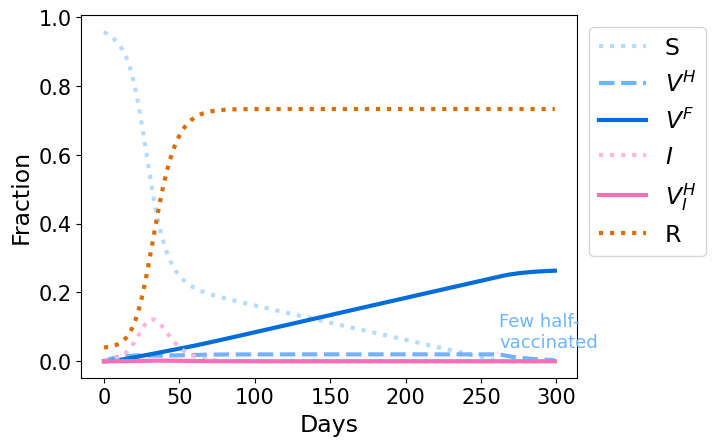

In [8]:
dynamics(R0=2, file_name="dynamics_R2")

## Figure 1 c

Total burden: 6.99e-01 
Total number of mutants: 4.73e-06


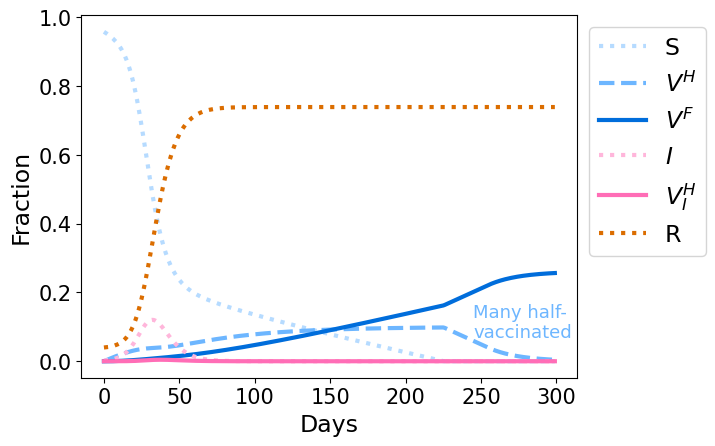

In [9]:
dynamics(R0=2, w=100, file_name="dynamics_R2_Omega100")

### Plot the metrics for x or y fixed

In [10]:
def sus_trans(effect, constEffect=1, R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, mu1=mu1D, mu_ratio=mu_ratioD,
             name="default"):
    zV = np.linspace(1, 0, 3)
    wV = np.linspace(100, 20, 25)
    recoveredV = []
    recoveredSV = []
    recoveredVaccV = []
    mutV = []
    mutSV = []
    mutVaccV = []
    for z in zV:
        if effect == "susceptibility":
            x = z
            y = constEffect
        else:
            y = z
            x = constEffect
        tempRecovered = []
        tempRecoveredS = []
        tempRecoveredVacc = []
        tempMut = []
        tempMutS = []
        tempMutVacc = []
        for w in wV:
            metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                      x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
            tempRecovered.append(metrics[0])
            tempRecoveredVacc.append(metrics[1])
            tempMut.append(metrics[2])
            tempMutVacc.append(metrics[3])
            tempRecoveredS.append(metrics[4])
            tempMutS.append(metrics[5])
        recoveredV.append(tempRecovered)
        recoveredVaccV.append(tempRecoveredVacc)
        recoveredSV.append(tempRecoveredS)
        mutV.append(tempMut)
        mutVaccV.append(tempMutVacc)
        mutSV.append(tempMutS)

    labels = ['1 (no effect)', '0.5', '0 (full effect)']
    line_styles = [':', '--', '-']
    if effect == "susceptibility":
        x_label = r"Susceptibility reduction $x$"
        color_map = ['k', '#fb9a99', '#e31a1c']
    else:
        x_label = r"Transmissibility reduction $y$"
        color_map = ['k', '#a6cee3', '#1f78b4']
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    min_burden = np.amin(np.array([recoveredV, recoveredSV, recoveredVaccV]))
    max_burden = np.amax(np.array([recoveredV, recoveredSV, recoveredVaccV]))
    min_mutant = np.amin(np.array([mutV, mutSV, mutVaccV]))
    max_mutant = np.amax(np.array([mutV, mutSV, mutVaccV]))
    min_burden -= (max_burden - min_burden) / 20
    max_burden += (max_burden - min_burden) / 20
    min_mutant -= (max_mutant - min_mutant) / 20
    max_mutant += (max_mutant - min_mutant) / 20

    fs = 15

    plt.figure(0)
    for i, z in enumerate(zV):
        plt.plot(wV, recoveredV[i], label=labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel(r'Burden $B$', fontsize=fs)
    plt.xlabel(r'Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat="%1.2f", offset=False, mathText=False))
    plt.ylim(min_burden, max_burden)
    plt.savefig('./Fig/x_or_y/' + effect  + '_burden_' + name + '.pdf', bbox_inches='tight')
    #plt.clf()

    plt.figure(1)
    for i, z in enumerate(zV):
        plt.plot(wV, recoveredSV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel(r'Burden from unvaccinated $B^S$', fontsize=fs)
    plt.xlabel(r'Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat="%1.2f", offset=False, mathText=False))
    plt.ylim(min_burden, max_burden)
    plt.savefig('./Fig/x_or_y/' + effect  + '_burden_S_' + name + '.pdf', bbox_inches='tight')
    #plt.clf()

    plt.figure(2)
    for i, z in enumerate(zV):
        plt.plot(wV, recoveredVaccV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel(r'Burden from half-vaccinated $B^H$', fontsize=fs)
    plt.xlabel(r'Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat="%1.2f", offset=False, mathText=False))
    plt.ylim(min_burden, max_burden)
    legend = plt.legend(title = x_label, loc='upper left', fontsize=fontsize_legend, frameon=False)
    legend.get_title().set_fontsize(fontsize_legend)
    plt.savefig('./Fig/x_or_y/' + effect  + '_burden_H_' + name + '.pdf', bbox_inches='tight')
    #plt.clf()

    plt.figure(3)
    for i, z in enumerate(zV):
        plt.plot(wV, mutV[i], label=labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel(r'Escape risk $M$', fontsize=fs)
    plt.xlabel(r'Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.ylim(min_mutant, max_mutant)
    plt.savefig('./Fig/x_or_y/' + effect  + '_mutants_' + name + '.pdf', bbox_inches='tight')
    #plt.clf()

    plt.figure(4)
    for i, z in enumerate(zV):
        plt.plot(wV, mutSV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel(r'Escape risk from unvaccinated $M^S$', fontsize=fs)
    plt.xlabel(r'Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.ylim(min_mutant, max_mutant)
    plt.savefig('./Fig/x_or_y/' + effect  + '_mutants_S_' + name + '.pdf', bbox_inches='tight')
    #plt.clf()

    plt.figure(5)
    for i, z in enumerate(zV):
        plt.plot(wV, mutVaccV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel(r'Escape risk from half-vaccinated $M^H$', fontsize=fs)
    plt.xlabel(r'Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.ylim(min_mutant, max_mutant)
    legend = plt.legend(title = x_label, loc='upper left', fontsize=fontsize_legend, frameon=False)
    legend.get_title().set_fontsize(fontsize_legend)
    plt.savefig('./Fig/x_or_y/' + effect  + '_mutants_H_' + name + '.pdf', bbox_inches='tight')
    #plt.clf()

## Figure 2 a-f

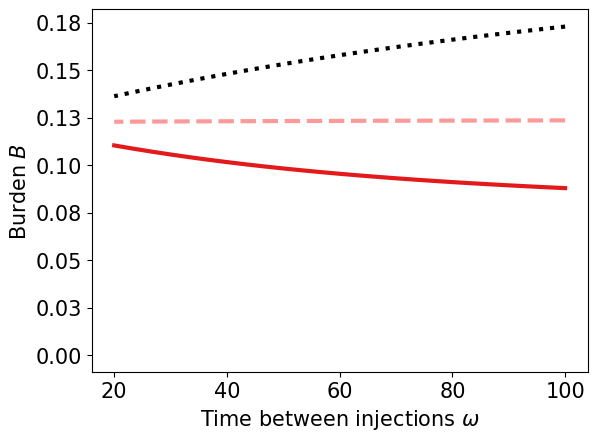

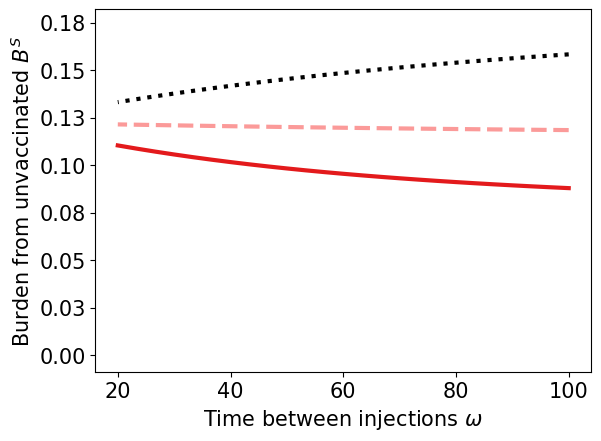

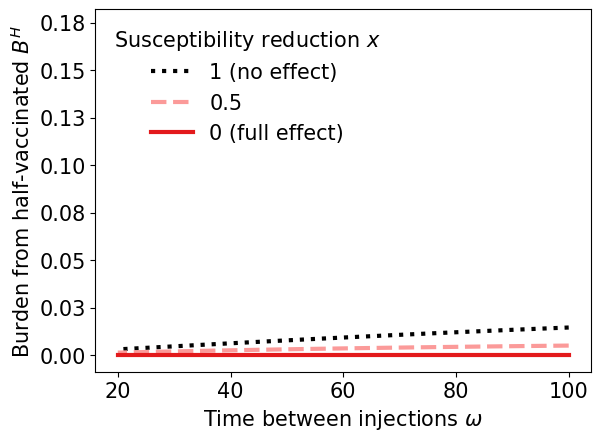

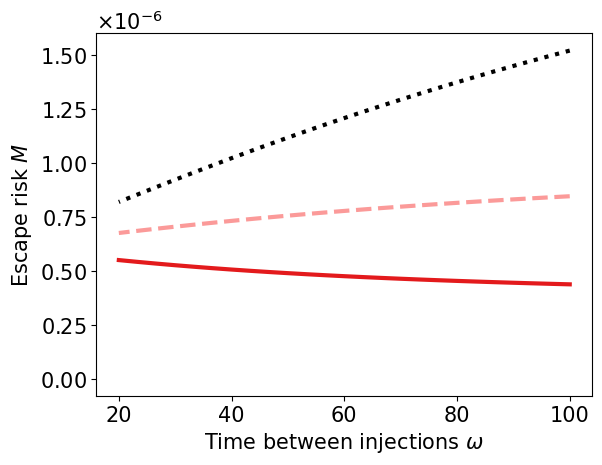

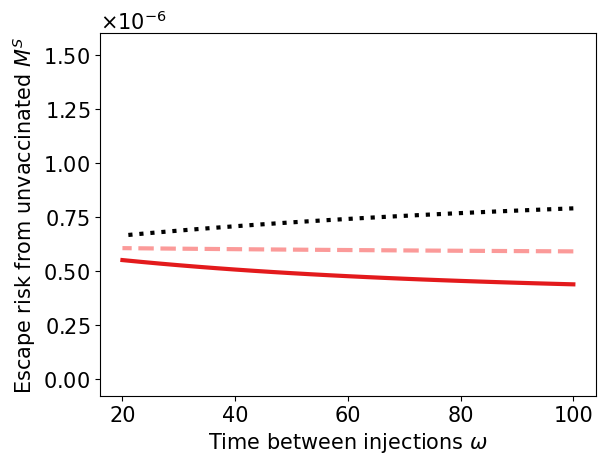

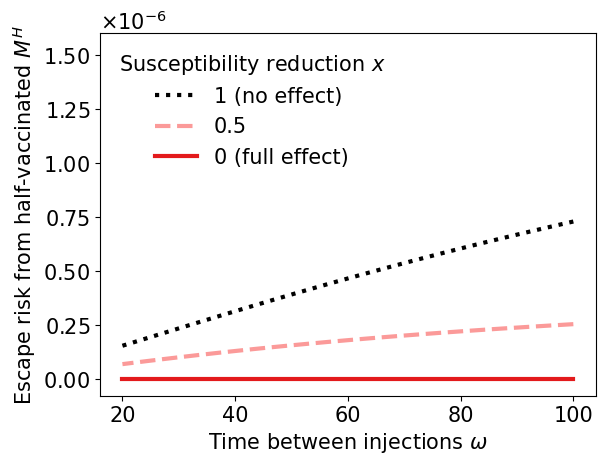

In [11]:
sus_trans(effect="susceptibility")

## Figure 2 g-l

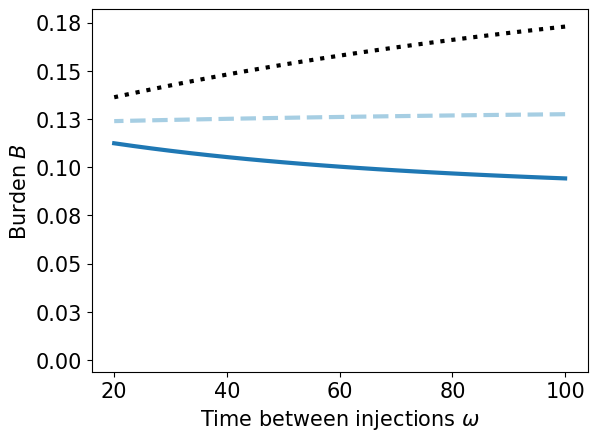

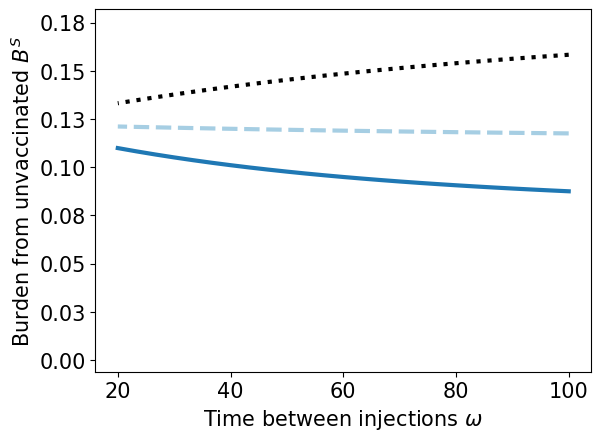

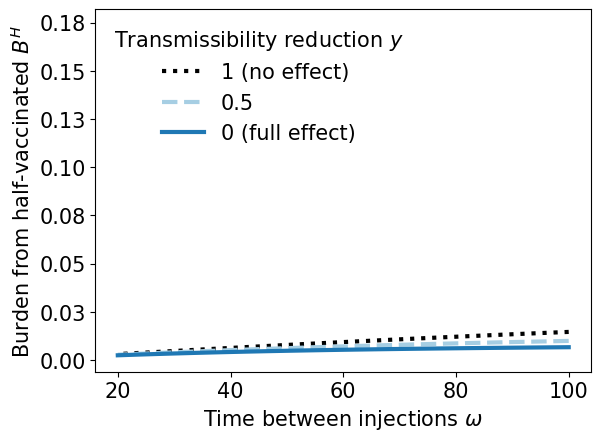

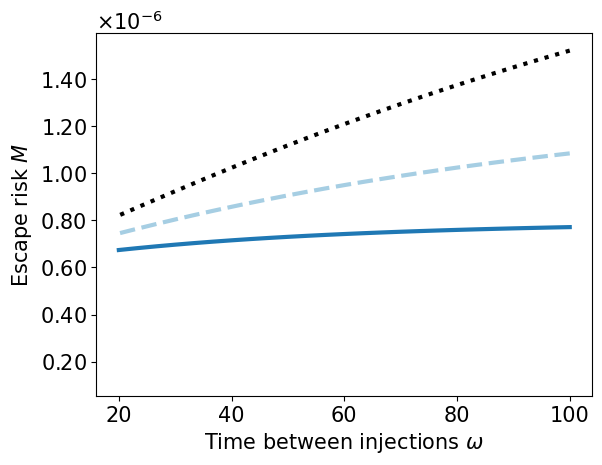

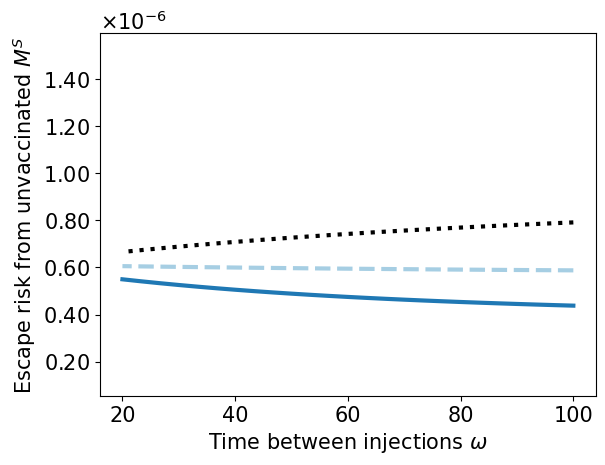

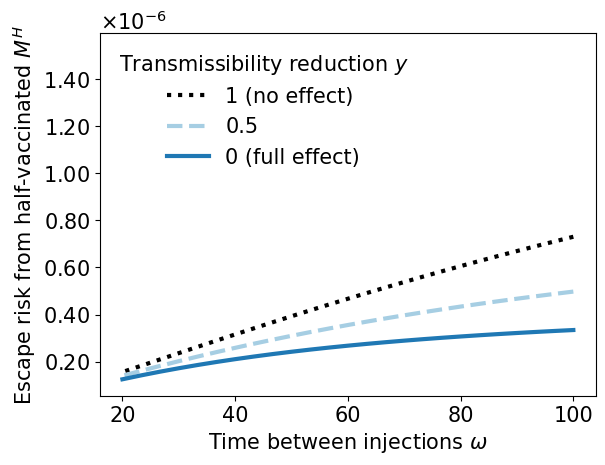

In [12]:
sus_trans(effect="transmissibility")

### Plot the metrics varying x and y

In [13]:
def plot_heatmap(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, mu1=mu1D, mu_ratio=mu_ratioD,
                 name="default", folder="diff/", is_absolute_values=False, is_diff=True, is_burden=True):
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    tauStep = 2    # 2 is enough to compute the diff between w=100 and w=20, but you need more if you want to explore intermediate strategies
    wV = np.linspace(20, 100, tauStep)
    minW = min(wV)
    maxW = max(wV)
    minWRecoveredV = np.zeros((xStep, xStep))
    maxWRecoveredV = np.zeros((xStep, xStep))
    minWMutV = np.zeros((xStep, xStep))
    maxWMutV = np.zeros((xStep, xStep))
    for i, y in enumerate(yV):
        for j, x in enumerate(xV):
            minRecovered = sys.float_info.max
            minMut = sys.float_info.max
            # optWRecovered = wV[0]
            # optWMut = wV[0]
            for w in wV:
                metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                          x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                if w == minW:
                    minWRecoveredV[i, j] = metrics[0]
                    minWMutV[i, j] = metrics[2]
                if w == maxW:
                    maxWRecoveredV[i, j] = metrics[0]
                    maxWMutV[i, j] = metrics[2]

    xV, yV = np.meshgrid(xV, yV)
    diffRecoveredV = maxWRecoveredV - minWRecoveredV
    diffMutV = maxWMutV - minWMutV
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)

    vmax_B = max(np.amax(np.array(maxWRecoveredV)), np.amax(np.array(minWRecoveredV)))
    vmin_B = min(np.amin(np.array(maxWRecoveredV)), np.amin(np.array(minWRecoveredV)))
    vmax_M = max(np.amax(np.array(maxWMutV)), np.amax(np.array(minWMutV)))
    vmin_M = min(np.amin(np.array(maxWMutV)), np.amin(np.array(minWMutV)))


    if is_absolute_values:
        plt.figure(0)
        levels = np.linspace(vmin_B, vmax_B, 20)
        ticks = np.linspace(vmin_B, vmax_B, 6)
        plt.pcolormesh(xV, yV, maxWRecoveredV, shading='gouraud', cmap=cm.viridis, vmin=vmin_B, vmax=vmax_B)
        bar = plt.colorbar(ticks=ticks, extend='both')
        bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
        plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
        plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
        plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
        plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
        plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
        plt.savefig('./Fig/' + folder + 'burden_Omega100_' + name + '.pdf', bbox_inches='tight')
        #plt.clf()

        plt.figure(1)
        plt.pcolormesh(xV, yV, minWRecoveredV, shading='gouraud', cmap=cm.viridis, vmin=vmin_B, vmax=vmax_B)
        bar = plt.colorbar(ticks=ticks, extend='both')
        bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
        plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
        plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
        plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
        plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
        plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
        plt.savefig('./Fig/' + folder + 'burden_Omega20_' + name + '.pdf', bbox_inches='tight')
        #plt.clf()

        plt.figure(2)
        levels = np.linspace(vmin_M, vmax_M, 20)
        ticks = np.linspace(vmin_M, vmax_M, 6)
        plt.pcolormesh(xV, yV, maxWMutV, shading='gouraud', cmap=cm.plasma, vmin=vmin_M, vmax=vmax_M)
        bar = plt.colorbar(ticks=ticks, extend='both')
        bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
        bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
        plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
        plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
        plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
        plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
        plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
        plt.savefig('./Fig/' + folder + 'mutants_Omega100_' + name + '.pdf', bbox_inches='tight')
        #plt.clf()

        plt.figure(3)
        plt.pcolormesh(xV, yV, minWMutV, shading='gouraud', cmap=cm.plasma, vmin=vmin_M, vmax=vmax_M)
        bar = plt.colorbar(ticks=ticks, extend='both')
        bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
        bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
        plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
        plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
        plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
        plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
        plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
        plt.savefig('./Fig/' + folder + 'mutants_Omega20_' + name + '.pdf', bbox_inches='tight')
        #plt.clf()



    vmax_B = max(abs(np.amin(np.array(diffRecoveredV))), abs(np.amax(np.array(diffRecoveredV))))
    vmax_M = max(abs(np.amin(np.array(diffMutV))), abs(np.amax(np.array(diffMutV))))

    def compute_diff_ticks(min, max, nb_max_ticks):
        is_transparent_tick = False
        ticks = [0]
        step = (max - min) / (nb_max_ticks - 1)
        t = 0
        while t >= min:
            t -= step
            ticks.append(t)
        t = 0
        while t <= max:
            t += step
            ticks.append(t)
        if step > - min:
            # ticks.append(step / 2)
            ticks.append(min)
            is_transparent_tick = True
        ticks = np.sort(np.array(ticks))
        return ticks, is_transparent_tick

    if is_diff:
        if is_burden:
            plt.figure(4)
            ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
            divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
            plt.contourf(xV, yV, diffRecoveredV, 20, norm=divnorm, cmap=cm.PRGn, extend='max')
            bar = plt.colorbar(ticks=ticks)
            bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.1f"))
            bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
            bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
            bar.ax.plot([-1, 1], [0, 0], 'k:')
            plt.contour(xV, yV, diffRecoveredV, 0, colors='k', linestyles='dashed')
            plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
            plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
            plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
            plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
            plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
            plt.text(0.1, 0.2, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
            plt.text(0.7, 0.8, 'No\ndelay', fontsize=18, color='black', va='center')
            if is_transparent_tick:
                bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                bar.ax.get_yticklabels()[0].set_alpha(0)
            plt.savefig('./Fig/' + folder + 'diff_burden_' + name + '.pdf', bbox_inches='tight')
            #plt.clf()

        plt.figure(5)
        ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
        divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
        plt.contourf(xV, yV, diffMutV, 20, norm=divnorm, cmap=cm.BrBG, extend='max')
        bar = plt.colorbar(ticks=ticks)
        bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.1f"))
        bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
        bar.ax.plot([-1, 1], [0, 0], 'k:')
        plt.contour(xV, yV, diffMutV, 0, colors='k', linestyles='dashed')
        plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
        plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
        plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
        plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
        plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
        if "MuRatio100" not in name and name != "R2" and name != "Lambda2":
            plt.text(0.1, 0.2, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
            plt.text(0.7, 0.8, 'No\ndelay', fontsize=18, color='black', va='center')
        if is_transparent_tick:
            bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
            bar.ax.get_yticklabels()[0].set_alpha(0)
        plt.savefig('./Fig/' + folder + 'diff_mutants_' + name + '.pdf', bbox_inches='tight')
        #plt.clf()

## Figure 3

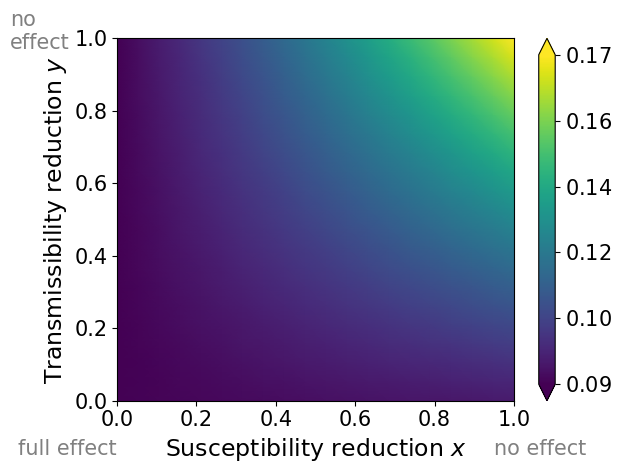

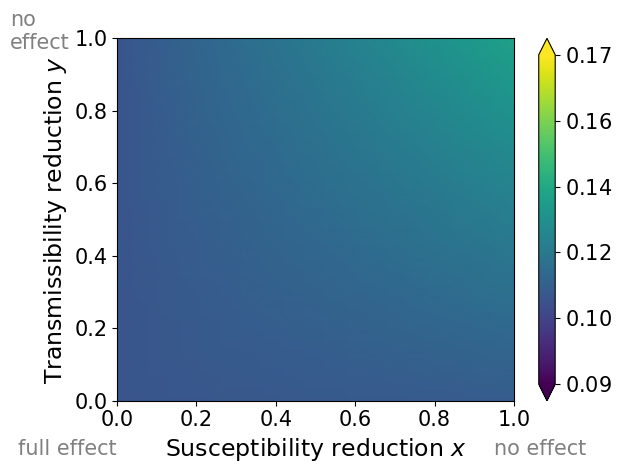

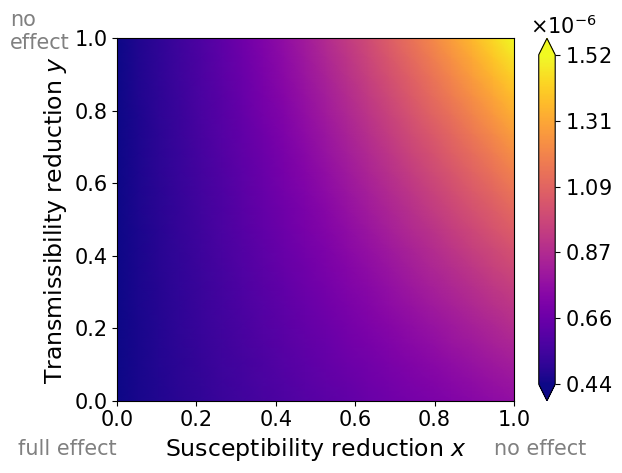

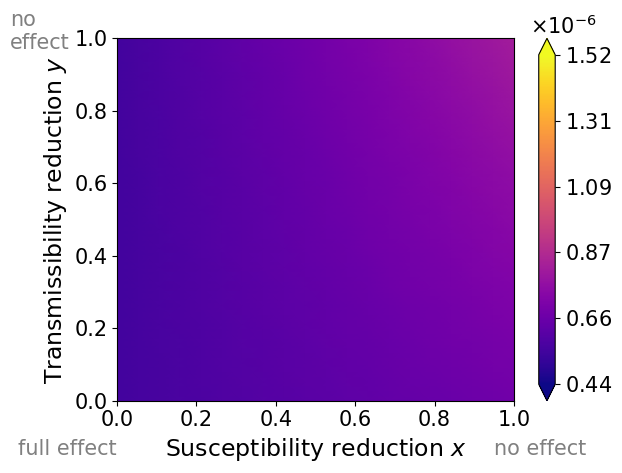

In [14]:
plot_heatmap(folder="absolute/", is_absolute_values=True, is_diff=False)

## Figure 4 a and g

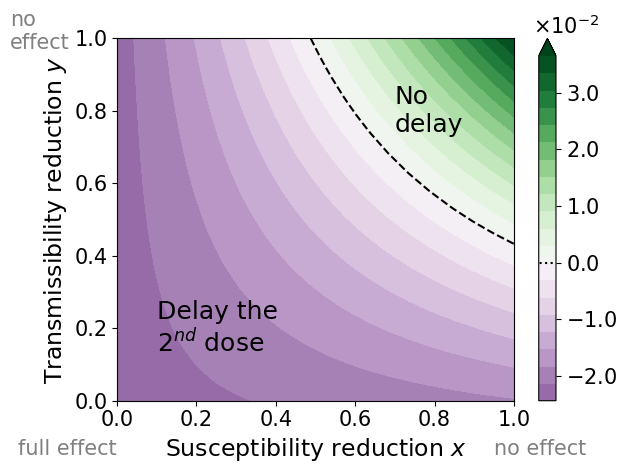

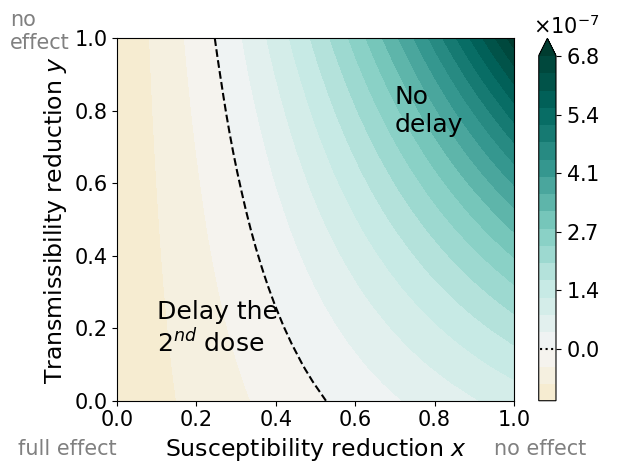

In [15]:
plot_heatmap()

## Figure 4 d

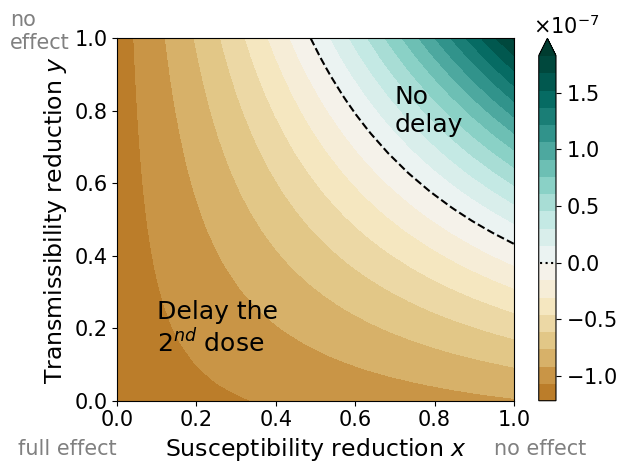

In [16]:
plot_heatmap(mu_ratio=1, name="MuRatio1", is_burden=False)

## Figure 4 j

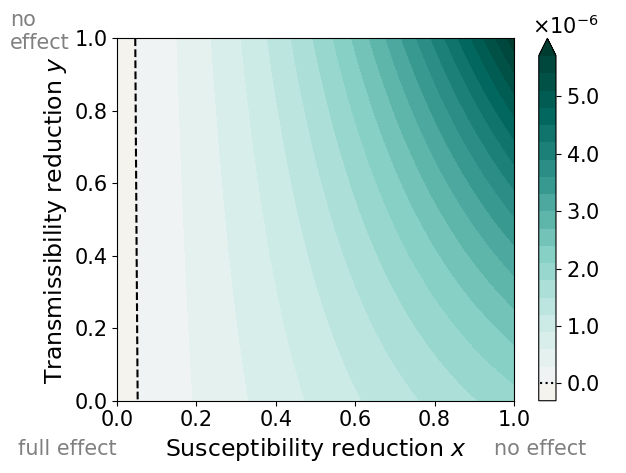

In [17]:
plot_heatmap(mu_ratio=100, name="MuRatio100", is_burden=False)

## Figure 4 b and h

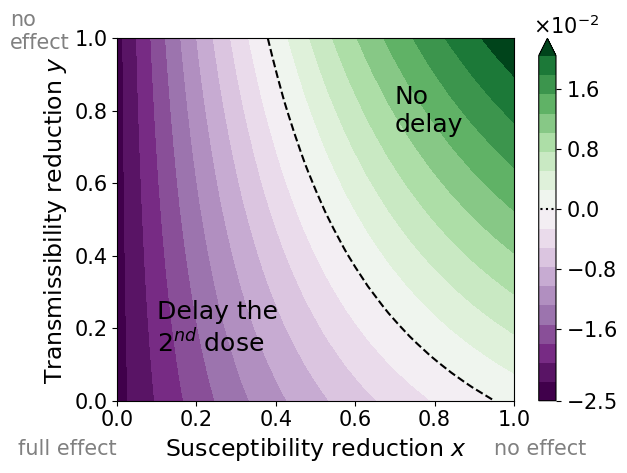

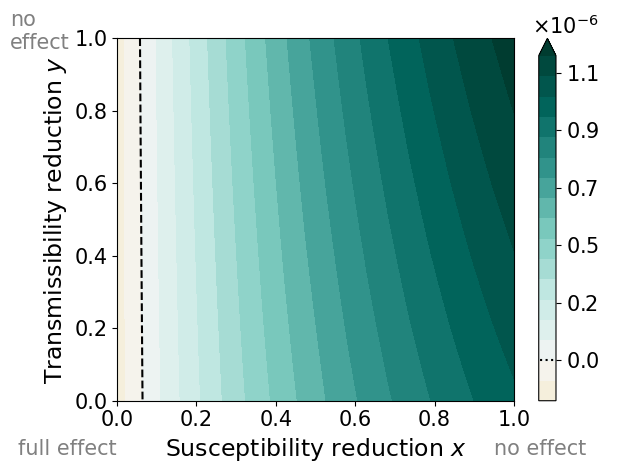

In [18]:
plot_heatmap(R0=2, name="R2")

## Figure 4 e

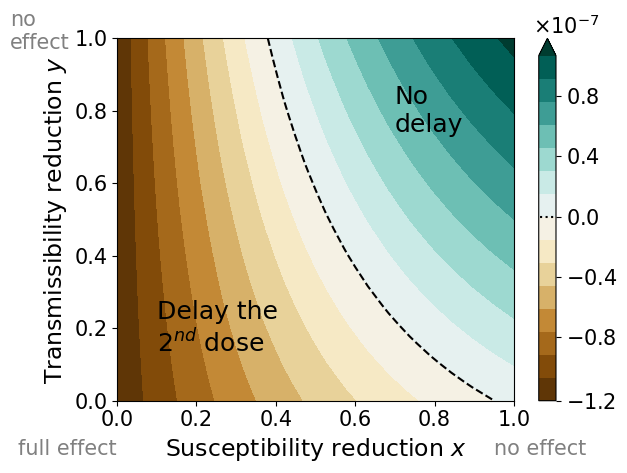

In [19]:
plot_heatmap(R0=2, mu_ratio=1, name="MuRatio1_R2", is_burden=False)

## Figure 4 k

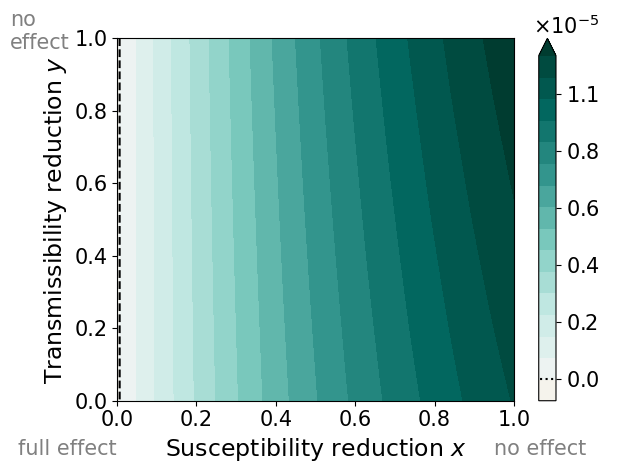

In [20]:
plot_heatmap(R0=2, mu_ratio=100, name="MuRatio100_R2", is_burden=False)

## Figure 4 c and i

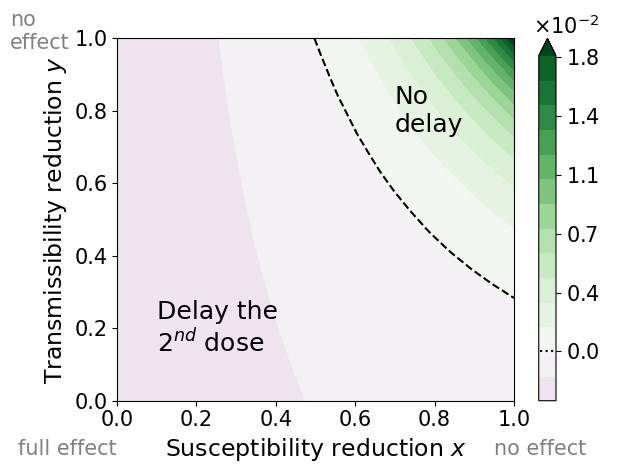

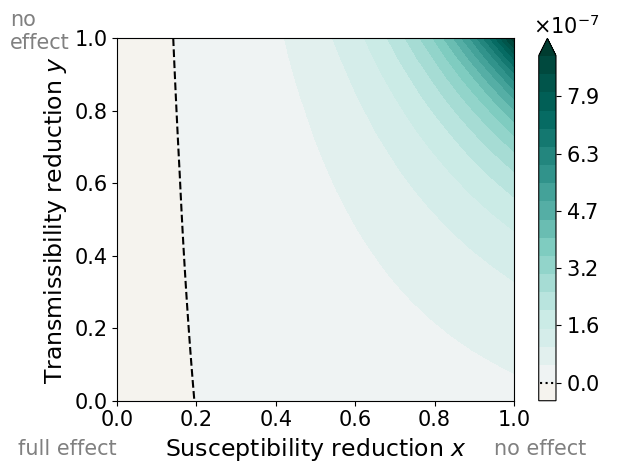

In [21]:
plot_heatmap(l=0.02, name="Lambda2")

## Figure 4 e

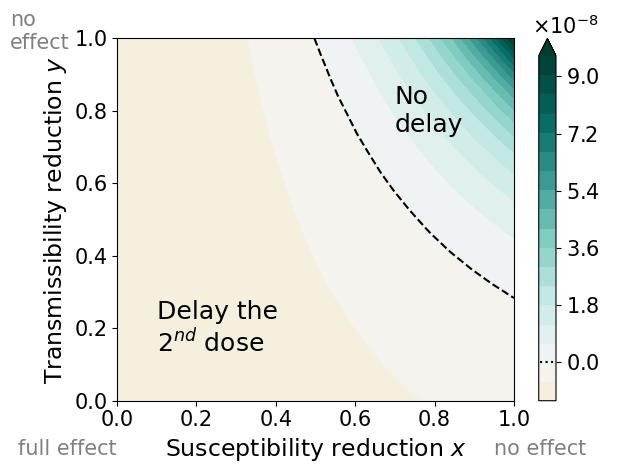

In [22]:
plot_heatmap(l=0.02, mu_ratio=1, name="MuRatio1_Lambda2", is_burden=False)

## Figure 4 k

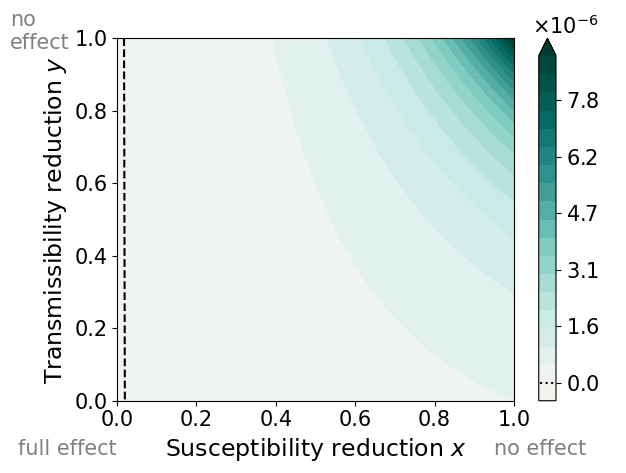

In [23]:
plot_heatmap(l=0.02, mu_ratio=100, name="MuRatio100_Lambda2", is_burden=False)

## Figure initial conditions b and e

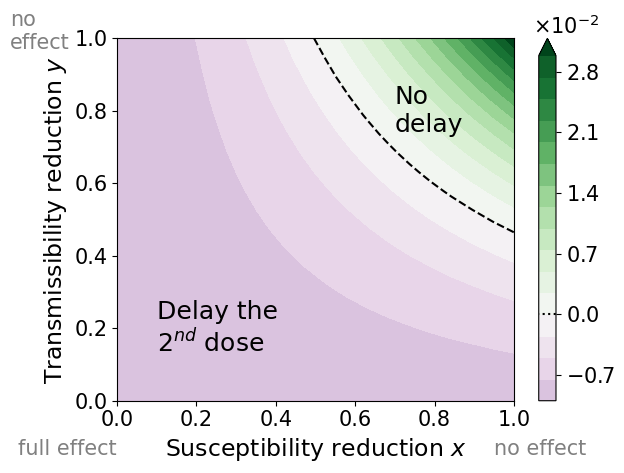

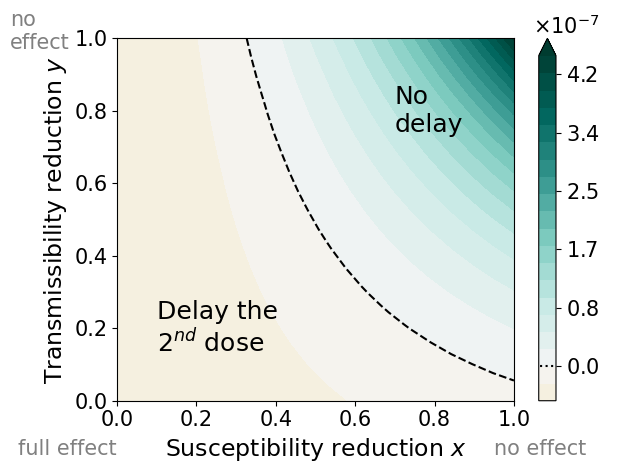

In [27]:
plot_heatmap(I0=2e-4, name="I02e-4", folder="initial_conditions/")

## Figure initial conditions c and f

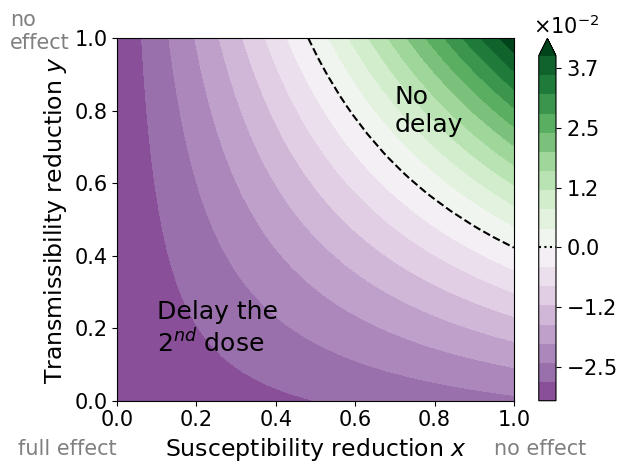

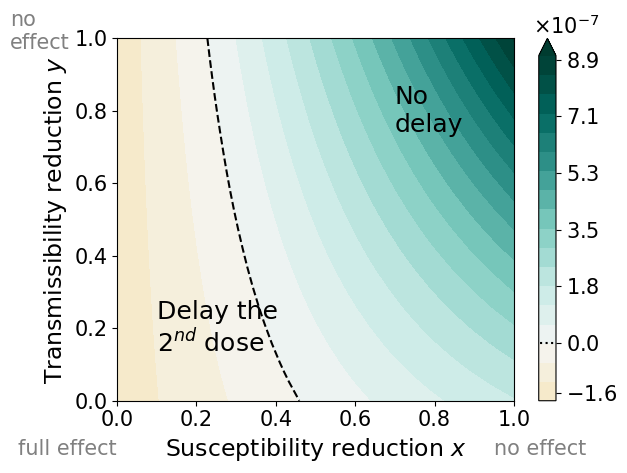

In [28]:
plot_heatmap(Rec0=4e-3, name="Rec04e-3", folder="initial_conditions/")

## Figure vaccine from start b and d

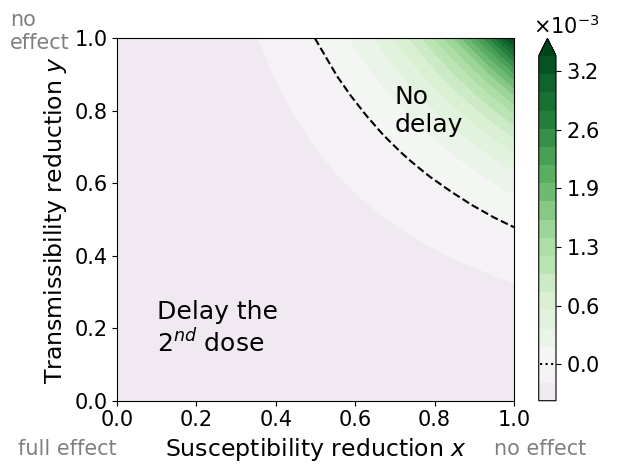

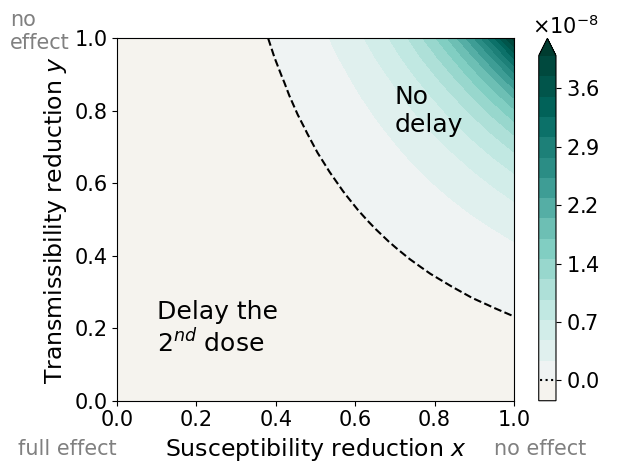

In [29]:
plot_heatmap(I0=1e-6, Rec0=0, name="I01e-6_Rec00", folder="initial_conditions/")